## 1. Install Dependencies and Setup

In [1]:
!pip install opencv-python

In [4]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

## 2. Load Data Pipeline

In [5]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [12]:
batch = data_iterator.next()

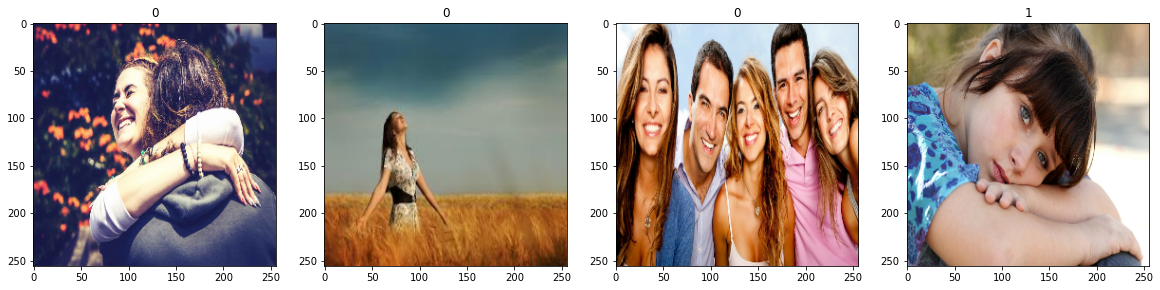

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 3. Scale Image Data

In [14]:
data = data.map(lambda x,y :(x/255, y))

## 4. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size= int(len(data)*.2)
test_size= int(len(data)*.1)

In [18]:
val_size

2

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 5. Build Deep Learning Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout

In [21]:
model = Sequential()

In [22]:
# Adding 3 Convolution layer with maxpooling and 2 Dense layer
model.add(Conv2D(16, (3,3),1, activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32,(3,3),1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16,(3,3),1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 6. Training CNN Models

In [25]:
logdir ='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train,epochs = 20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 21s 2s/step - loss: 0.4069 - accuracy: 0.8438 - val_loss: 0.4241 - val_accuracy: 0.8281
Epoch 2/20
7/7 [==============================] - 19s 2s/step - loss: 0.2907 - accuracy: 0.9018 - val_loss: 0.2364 - val_accuracy: 0.9375
Epoch 3/20
7/7 [==============================] - 21s 3s/step - loss: 0.2101 - accuracy: 0.9330 - val_loss: 0.1808 - val_accuracy: 0.9531
Epoch 4/20
7/7 [==============================] - 20s 3s/step - loss: 0.2175 - accuracy: 0.9196 - val_loss: 0.1956 - val_accuracy: 0.9688
Epoch 5/20
7/7 [==============================] - 21s 3s/step - loss: 0.1442 - accuracy: 0.9598 - val_loss: 0.0590 - val_accuracy: 0.9688
Epoch 6/20
7/7 [==============================] - 21s 3s/step - loss: 0.1438 - accuracy: 0.9375 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 20s 3s/step - loss: 0.0856 - accuracy: 0.9732 - val_loss: 0.0929 - val_accuracy: 0.9688
Epoch 8/20
7/7 [==================

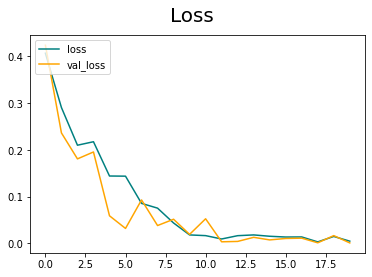

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

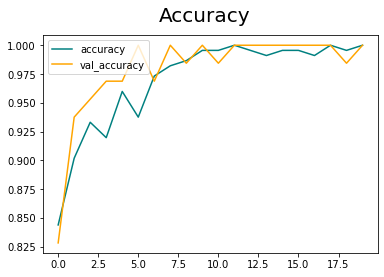

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 7. Evaluate Model Performance

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.875, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32)


## 8. Test on Unknown Data Image 

In [35]:
import cv2

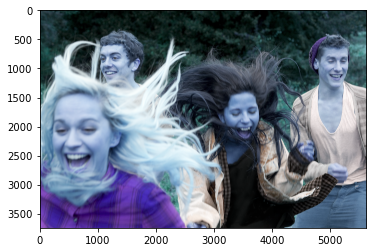

In [36]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

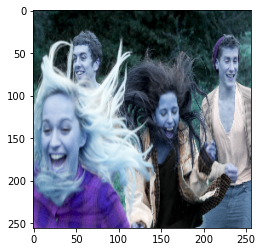

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 63ms/step


In [39]:
yhat

array([[0.01881484]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


## 9. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','Facial_image_classifier.h5'))

In [44]:
new_model = load_model('models/Facial_image_classifier.h5')

In [45]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 149ms/step


array([[0.01881484]], dtype=float32)